In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


array([[0, 1, 0, 1, 1, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 1]])


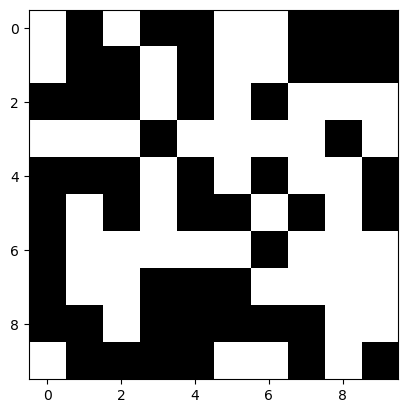

In [2]:
maze_size = (10, 10)  
maze_rand = np.random.choice([0, 1], size=maze_size)
print(repr(maze_rand))
plt.imshow(maze_rand, cmap='binary')
plt.show()

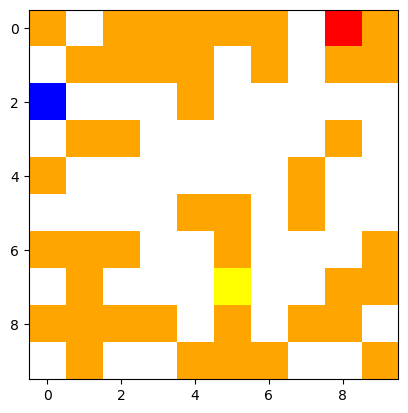

200
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2,

In [24]:
class Maze_env:
    def __init__(self , start, target, coins, maze):
        self.maze = maze
        self.target = target
        self.start = start
        self.coins = coins
        self.position = 0
        self.R = 0
        self.Q = 0
        self.states = []
        self.coin_collected = False
        self.terminate = False
        
    def plot_env(self):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[self.start] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()
        
    def plot_env_position(self, position, timestep):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[position] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.savefig(f'img/plot_{timestep:06d}.png', dpi=300)
        plt.show()
        plt.close() 
        
    def create_r_matrix(self):
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        num_states = self.maze.shape[0] * self.maze.shape[1]
        R = np.full((num_states, 4), np.nan)

        state_index = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
            # If the cell is not a wall
                if self.maze[i, j] == 0:
                    for index, action in enumerate(actions):
                        new_position = (i + action[0], j + action[1])
                        # If action leads to a valid state
                        if (0 <= new_position[0] < self.maze.shape[0] and
                            0 <= new_position[1] < self.maze.shape[1] and
                            self.maze[new_position] == 0):
                            # Calculate the state number for the new position
                            # Set reward to 0
                            R[state_index, index] = -5

                            # If action leads to goal state set reward to 100
                            if new_position == self.target:
                                R[state_index, index] = 1000
                            if new_position == self.coins:
                                R[state_index, index] = 200
                state_index += 1
                            
        self.R = R
        print(self.R.shape)
        return self.R
    
    def reward(self, state, action):
        state = self.states[state]
        x, y = state
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1
        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return -1  # hit a wall (including edges wall?)
        elif (x, y) == self.target:
            print("TRALALAAAAAAAAAAAAAAAAAAAAAA!")
            print((x,y))
            return 1 # reached the target and bonus if collected coin
        elif (x, y) == self.coins and not self.coin_collected:
            print("DING DING DOOOOOOOOOOONG")
            return 10
        else:
            return -0.005  # regular step
        
    def transition(self, state, action):
        state_new = self.states[state]
        x, y = state_new
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            self.terminate = True
            if self.coin_collected:
                return self.states.index(state_new) + 100  # hit a wall, stay in the same state
            return self.states.index(state_new)  # hit a wall, stay in the same state
        else:
            if (x, y) == self.coins:
                self.coin_collected = True
                return self.states.index((x,y)) + 100 #specific index for coin
            else:
                if (x, y) == self.target:
                    self.terminate = True
                if self.coin_collected:
                    return self.states.index((x,y)) + 100  # move to the new state
                return self.states.index((x,y))  # move to the new state
        
    def done(self):
        return self.terminate
    
    def create_q_matrix(self):
        coord_to_index = []
        for coin_presence in range(2):
            for i in range(self.maze.shape[0]):
                for j in range(self.maze.shape[1]):
                    coord_to_index.append((i,j))
        print(len(coord_to_index))
#         coord_to_index.append(self.coins)
        print(coord_to_index)
                
        num_states = 2*self.maze.shape[0] * self.maze.shape[1]
        num_actions = 4
        self.Q = np.zeros((num_states, num_actions))
        print(self.Q.shape)
        self.states = coord_to_index
        return self.Q, coord_to_index

maze = np.array([
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]])
# env = Maze_env((2,0),(0,8),(6,6), maze) 
env = Maze_env((2,0),(0,8),(7,5), maze) 
env.plot_env()
# R = env.create_r_matrix()
# print('R matrix: \n\n{}'.format(R))
Q, coord_to_index = env.create_q_matrix()
print(len(coord_to_index))
print('Q matrix: \n\n{}'.format(Q))




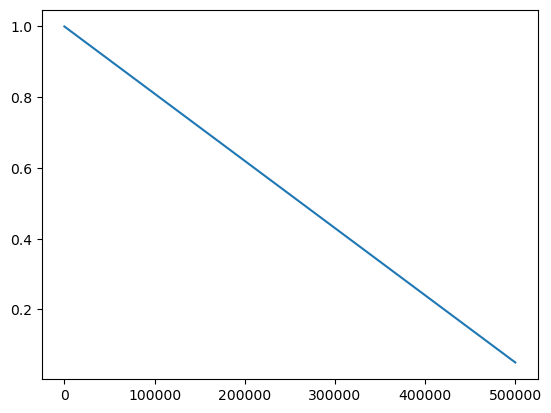

In [25]:
def plot_epsilon_decay(episodes, decay):
    max_episodes = episodes
    decay_limit = decay
    epsilon = 1
    epsilon_values = []
    for episode in range(max_episodes):
        epsilon = np.interp(episode, [0, max_episodes], [1, decay_limit])
        epsilon_values.append(epsilon)
    plt.plot(epsilon_values)
    plt.show()
    
plot_epsilon_decay(500000, 0.05)

    

In [26]:
class Q_learning:
    
    def __init__(self, alpha, gamma, epsilon, episodes, steps, env, states):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = 150.0
        self.states = states

#         self.R = env.R
#         self.R_mod = self.R.copy()
        self.Q = env.Q
        self.episodes = episodes
        self.steps = steps
        self.start = env.start
        self.target = self.states.index(env.target)
        self.coins = env.coins
        self.env = env
        self.episodes_rewards = []
        self.max_list_size = 10
        self.list_rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.threshold = 2
        self.window_size = 4
        self.current_average = 0
        
        print("Initial Q matrix is '{}'".format(self.Q))

    def plot_rewards(self):
        plt.plot(self.episodes_rewards)
        plt.show()
        
    def show_Q_spec(self,coord):
        print(q_learning.Q[self.states.index(coord)])
        
    def show_Q_spec_state(self,state):
        print(q_learning.Q[state])
        
    def greedy_policy(self, state):
#                 available_actions = np.where(~np.isnan(self.R_mod[s]))[0]
#                 q_values = [self.Q[s,a] for a in available_actions]
#                 best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
        
        available_actions = np.array([0,1,2,3])
        q_values = [self.Q[state,a] for a in available_actions]
        best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]

        if np.random.uniform() < self.epsilon:
            a = np.random.choice(4)
#                     a = np.random.choice(available_actions)
        else:
#                     a = np.argmax(self.Q[s,:])
            a = np.random.choice(best_actions)
        return a
    
    def softmax_policy(self, state, temperature = 1.0):
        available_actions = np.array([0,1,2,3])
        q_values = np.array([self.Q[state,a] for a in available_actions])
        max_q_value = np.max(q_values)
        exp_values = np.exp((q_values - max_q_value) / temperature)
        action_probs = exp_values / np.sum(exp_values)

        # Sample an action based on the probabilities
        selected_action = np.random.choice(len(action_probs), p=action_probs)
        return selected_action
        
    def train(self):
        print(self.states)
#         print("Starting taget is '{}'".format(self.target))
        for episode in range(self.episodes):
            s = self.states.index(self.start)
#             print("Starting state is '{}'".format(s))
            episode_reward = 0
            env.coin_collected = False
            env.terminate = False
#             self.R_mod = self.R
            for timestep in range(self.steps):

                # Epsilon-greedy action choice
                a = self.greedy_policy(s)
#                 a = self.softmax_policy(s, self.temperature)

                # Environment updating
                r = env.reward(s, a)
#                 r = self.R_mod[s,a]
                episode_reward += r
                new_s = env.transition(s, a)
                # Doubts coordinates to Q system?
                # Q value updating
#                 print(new_s)
                self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * np.max(self.Q[new_s,:]) - self.Q[s,a])

                if env.done():
                    break
                s = new_s
            
            self.episodes_rewards.append(episode_reward)
            
            self.list_rewards.append(episode_reward)
            if len(self.list_rewards) > self.max_list_size:
                self.list_rewards.pop(0)
            window = self.list_rewards[-self.window_size:]
            window_average = sum(window) / self.window_size
#             if abs(self.current_average - window_average) < self.threshold:
#                 print(f"Average exceeded threshold at episode {episode}. STOPPING!")
#                 break 
            self.current_average = window_average

            if episode % 100 == 0:
                print('Episode {} finished. Episode Reward {}. Timesteps {}. Average {}'.format(episode,episode_reward,timestep, window_average))
#             if episode > 5000 and episode < 200000:
#                 self.epsilon = max(self.epsilon*0.9999,0.5)
# #                 self.temperature = max(self.temperature*0.995,0.01)
#             if episode > 200000:
#                 self.epsilon = max(self.epsilon*0.9999,0.05)
#             print(self.epsilon)
            self.epsilon = np.interp(episode, [0, self.episodes], [1, 0.05])


            
    def create_video(self):
        image_folder = 'img'  # Directory containing your saved plot images
        video_name = 'video_agent.mp4'

        images = [img for img in os.listdir(image_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    
    def test(self, limit):
        s = self.states.index(self.start)
        print("Starting state is '{}'".format(s))
        episode_reward = 0
        env.coin_collected = False
        env.terminate = False
        for timestep in range(limit):
            print("Step {}".format(timestep))
            self.env.plot_env_position(self.states[s], timestep)
            print(self.Q[s])
            a = np.argmax(self.Q[s])
            print(a)

            # Environment updating
            r = env.reward(s, a)
            print(r)
            episode_reward += r
            temp_new_s = env.transition(s, a)
#             new_s = self.states.index(temp_new_s)

            if env.done():
                self.env.plot_env_position(self.states[temp_new_s], timestep)
                break
            s = temp_new_s
        print('Episode Reward {}.Q matrix values:\n{}'.format(episode_reward,self.Q.round(1)))
        self.create_video()



            

In [27]:
q_learning = Q_learning(1, 0.999, 1, 400000, 200, env, coord_to_index)
q_learning.train()

Initial Q matrix is '[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

Episode 8200 finished. Episode Reward -1.005. Timesteps 1. Average -1.0062499999999999
Episode 8300 finished. Episode Reward -1.005. Timesteps 1. Average -1.0087499999999998
Episode 8400 finished. Episode Reward -1.005. Timesteps 1. Average -1.0062499999999999
Episode 8500 finished. Episode Reward -1.015. Timesteps 3. Average -1.0074999999999998
Episode 8600 finished. Episode Reward -1.03. Timesteps 6. Average -1.01
Episode 8700 finished. Episode Reward -1. Timesteps 0. Average -1.005
Episode 8800 finished. Episode Reward -1.03. Timesteps 6. Average -1.01
Episode 8900 finished. Episode Reward -1. Timesteps 0. Average -1.00375
Episode 9000 finished. Episode Reward -1.01. Timesteps 2. Average -1.01
Episode 9100 finished. Episode Reward -1. Timesteps 0. Average -1.0025
Episode 9200 finished. Episode Reward -1. Timesteps 0. Average -1.0074999999999998
Episode 9300 finished. Episode Reward -1.005. Timesteps 1. Average -1.0062499999999999
Episode 9400 finished. Episode Reward -1.005. Timeste

Episode 38500 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
Episode 38600 finished. Episode Reward -1.005. Timesteps 1. Average -1.0062499999999999
Episode 38700 finished. Episode Reward -1.01. Timesteps 2. Average -1.0125
Episode 38800 finished. Episode Reward -1. Timesteps 0. Average -1.0062499999999999
Episode 38900 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
Episode 39000 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
Episode 39100 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
Episode 39200 finished. Episode Reward -1.01. Timesteps 2. Average -1.0062499999999999
Episode 39300 finished. Episode Reward -1.005. Timesteps 1. Average -1.0025
Episode 39400 finished. Episode Reward -1.005. Timesteps 1. Average -1.01125
Episode 39500 finished. Episode Reward -1.005. Timesteps 1. Average -1.00375
Episode 39600 finished. Episode Reward -1. Timesteps 0. Average -1.005
Episode 39700

Episode 67300 finished. Episode Reward -1.015. Timesteps 3. Average -1.0225
Episode 67400 finished. Episode Reward -1.005. Timesteps 1. Average -1.0174999999999998
Episode 67500 finished. Episode Reward -1.005. Timesteps 1. Average -1.02875
Episode 67600 finished. Episode Reward -1. Timesteps 0. Average -1.0062499999999999
Episode 67700 finished. Episode Reward -1.005. Timesteps 1. Average -1.0087499999999998
Episode 67800 finished. Episode Reward -1. Timesteps 0. Average -1.005
Episode 67900 finished. Episode Reward -1. Timesteps 0. Average -1.00875
Episode 68000 finished. Episode Reward -1.005. Timesteps 1. Average -1.0087499999999998
DING DING DOOOOOOOOOOONG
Episode 68100 finished. Episode Reward -1. Timesteps 0. Average -1.0025
Episode 68200 finished. Episode Reward -1.015. Timesteps 3. Average -1.0112499999999998
Episode 68300 finished. Episode Reward -1.015. Timesteps 3. Average -1.0099999999999998
Episode 68400 finished. Episode Reward -1.005. Timesteps 1. Average -1.00375
DING 

Episode 95700 finished. Episode Reward -1.02. Timesteps 4. Average -1.0175
Episode 95800 finished. Episode Reward -1.005. Timesteps 1. Average -1.02875
Episode 95900 finished. Episode Reward -1.005. Timesteps 1. Average -1.0162499999999999
Episode 96000 finished. Episode Reward -1.045. Timesteps 9. Average -1.0162499999999999
Episode 96100 finished. Episode Reward -1.015. Timesteps 3. Average -1.02375
Episode 96200 finished. Episode Reward -1.005. Timesteps 1. Average -1.00375
Episode 96300 finished. Episode Reward -1.01. Timesteps 2. Average -1.01
Episode 96400 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
Episode 96500 finished. Episode Reward -1.005. Timesteps 1. Average -1.01375
Episode 96600 finished. Episode Reward -1.015. Timesteps 3. Average -1.01625
Episode 96700 finished. Episode Reward -1.01. Timesteps 2. Average -1.0062499999999999
DING DING DOOOOOOOOOOONG
Episode 96800 finished. Episode Reward -1.005. Timesteps 1. Average -1.00375
DING DING DOOO

Episode 110400 finished. Episode Reward -1.005. Timesteps 1. Average -1.005
Episode 110500 finished. Episode Reward -1.055. Timesteps 11. Average -1.0187499999999998
Episode 110600 finished. Episode Reward -1.025. Timesteps 5. Average -1.0099999999999998
Episode 110700 finished. Episode Reward -1.005. Timesteps 1. Average -1.005
DING DING DOOOOOOOOOOONG
Episode 110800 finished. Episode Reward -1.01. Timesteps 2. Average -1.0125
Episode 110900 finished. Episode Reward -1.015. Timesteps 3. Average -1.005
Episode 111000 finished. Episode Reward -1.02. Timesteps 4. Average -1.0225
Episode 111100 finished. Episode Reward -1.01. Timesteps 2. Average -1.015
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 111200 finished. Episode Reward -1. Timesteps 0. Average -1.005
DING DING DOOOOOOOOOOONG
Episode 111300 finished. Episode Reward -1.015. Timesteps 3. Average -1.0087499999999998
DING DING DOOOOOOOOOOONG
Episode 111400 finished. Episode Reward -1. Timesteps 0. Average -1.007499999999

DING DING DOOOOOOOOOOONG
Episode 138400 finished. Episode Reward -1. Timesteps 0. Average -1.0187499999999998
DING DING DOOOOOOOOOOONG
Episode 138500 finished. Episode Reward -1.015. Timesteps 3. Average -1.01875
DING DING DOOOOOOOOOOONG
Episode 138600 finished. Episode Reward -1.04. Timesteps 8. Average -1.0174999999999998
Episode 138700 finished. Episode Reward -1.015. Timesteps 3. Average -1.0125
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 138800 finished. Episode Reward -1.01. Timesteps 2. Average -1.0112499999999998
DING DING DOOOOOOOOOOONG
Episode 138900 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
DING DING DOOOOOOOOOOONG
Episode 139000 finished. Episode Reward -1.005. Timesteps 1. Average -1.0187499999999998
DING DING DOOOOOOOOOOONG
Episode 139100 finished. Episode Reward -1.025. Timesteps 5. Average -1.0124999999999997
Episode 139200 finished. Episode Reward -1. Timesteps 0. Average -1.01
DING DING DOOOOOOOOOO

Episode 161200 finished. Episode Reward -1.025. Timesteps 5. Average -1.0124999999999997
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 161300 finished. Episode Reward -1.005. Timesteps 1. Average -1.0099999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 161400 finished. Episode Reward -1.005. Timesteps 1. Average -1.00375
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 161500 finished. Episode Reward -1. Timesteps 0. Average 1.4724999999999984
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 161600 finished. Episode Reward -1.015. Timesteps 3. Average -1.0162499999999999
DING DING DOOOOOOOOOOONG
Episode 161700 finished. Episode Reward -1.005. Timesteps 1. Average -1.005
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 161800 finished. Episode Reward -1. Timesteps 0. Average -1.00

Episode 174600 finished. Episode Reward -1.005. Timesteps 1. Average -1.005
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 174700 finished. Episode Reward -1.035. Timesteps 7. Average 1.4437499999999985
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 174800 finished. Episode Reward -1. Timesteps 0. Average -1.0074999999999998
DING DING DOOOOOOOOOOONG
Episode 174900 finished. Episode Reward -1.01. Timesteps 2. Average -1.01125
DING DING DOOOOOOOOOOONG
Episode 175000 finished. Episode Reward -1.015. Timesteps 3. Average -1.0187499999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 175100 finished. Episode Reward -1.005. Timesteps 1. Average -1.0099999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOO

Episode 185200 finished. Episode Reward -1.015. Timesteps 3. Average -1.01375
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 185300 finished. Episode Reward -1.015. Timesteps 3. Average -1.02
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 185400 finished. Episode Reward -1.005. Timesteps 1. Average -1.0074999999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 185500 finished. Episode Reward -1.005. Timesteps 1. Average -1.00875
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 185600 finished. Episode Reward 10.809999999999992. Timesteps 39. Average 1.947499999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOO

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
Episode 205500 finished. Episode Reward -1. Timesteps 0. Average -1.005
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 205600 finished. Episode Reward -1. Timesteps 0. Average 1.4725000000000001
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 205700 finished. Episode Reward -1. Timesteps 0. Average -1.00375
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
Episode 205800 finished. Episode Reward -1.01. Timesteps 2. Average -1.025
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOO

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 221200 finished. Episode Reward -1.01. Timesteps 2. Average -1.0162499999999999
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 221300 finished. Episode Reward -1.015. Timesteps 3. Average -1.0087499999999998
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 221400 finished. Episode Reward -1. Timesteps 0. Avera

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 230900 finished. Episode Reward -1.005. Timesteps 1. Average -1.01
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 231000 finished. Episode Reward -1.005. Timesteps 1. Average -1.01375
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
Episode 231100 finished. Episode Reward -1.05. Timesteps 10. 

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 235000 finished. Episode Reward -1.015. Timesteps 3. Average 1.4825000000000002
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 235100 finished. Episode Reward -1.015. Timesteps 3. Average -1.01
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAA

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 238400 finished. Episode Reward -1.025. Timesteps 5. Average -1.02
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 238500 finished. Episode Reward -1.04. Timesteps 8. Average 1.4562499999999985
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 238600 finished. Episode Reward 8.935. Timesteps 14. Average 1.4700000000000002
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOO

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 247800 finished. Episode Reward -1.085. Timesteps 17. Average -1.0325
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAA

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
Episode 259100 finished. Episode Reward -1.01. Timesteps 2. Average 1.4537499999999979
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 259200 finished. Episode Reward 10.909999999999993. Timesteps 19. Average 1.9712499999999984
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DI

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 265200 finished. Episode Reward -1.04. Timesteps 8. Average 1.9362499999999947
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 281700 finished. Episode Reward -1.07. Timesteps 14. Average 1.4575
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAA

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 301200 finished. Episode Reward -1.045. Timesteps 9. Average 1.4549999999999983
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
Episode 311700 finished. Episode Reward -1.005. Timeste

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 319800 finished. Episode Reward 10.899999999999993. Timesteps 21. Average 4.452499999999998
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAA

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
Episode 331300 finished. Episode Reward 8.944999999999999. Timesteps 12. Average 6.9374999999999964
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRAL

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 342800 finished. Episode Reward -1. Timesteps 0. Average 1.9587499999999967
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING 

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALA

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOO

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALAL

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 358400 finished. Episode Reward 10.899999999999993. Timesteps 21. Average 4.939999999999996
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING D

DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOO

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOO

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 382900 finished. Episode Reward 10.889999999999992. Timesteps 23. Average 7.429999999999996
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOO

DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 386100 finished. Episode Reward -1.005. Timesteps 1. Average 7.928749999999996
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0

TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
Episode 390600 finished. Episode Reward -1.015. Timesteps 3. Average 7.926249999999994
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
DING DING DOOOOOOOOOOONG
TRALALAAAAAAAAAAAAA

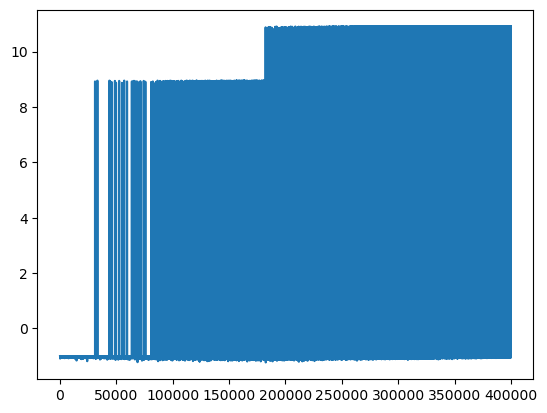

In [28]:
q_learning.plot_rewards()

Starting state is '20'
Step 0


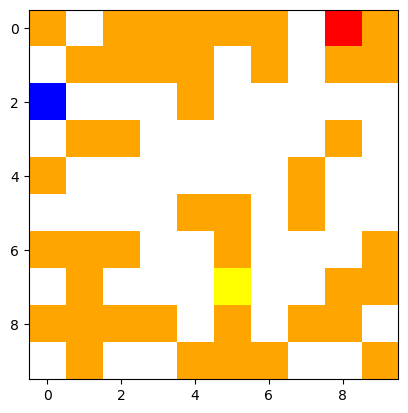

[10.77074568 10.77074568  9.79153222 10.80233455]
3
-0.005
Step 1


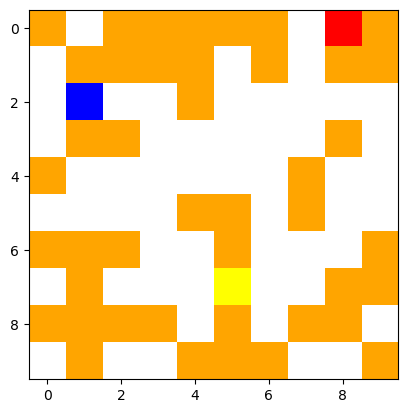

[ 9.80733455  9.80733455 10.78653222 10.8181527 ]
3
-0.005
Step 2


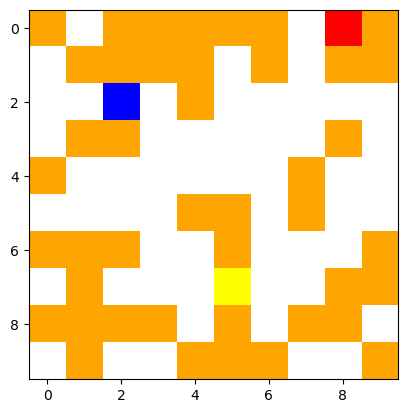

[ 9.8231527   9.8231527  10.80233455 10.83398669]
3
-0.005
Step 3


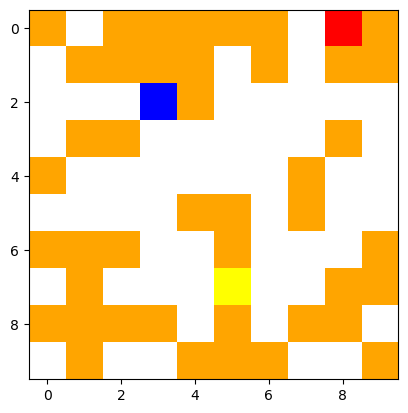

[ 9.83898669 10.84983653 10.8181527   9.83898669]
1
-0.005
Step 4


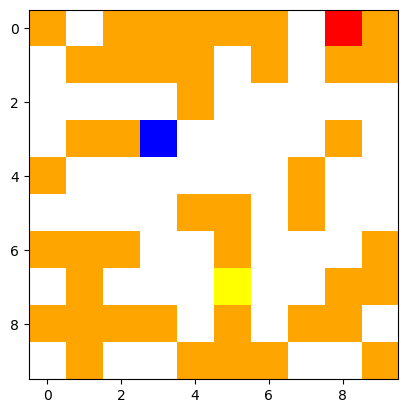

[10.83398669 10.86570223  9.85483653 10.83398669]
1
-0.005
Step 5


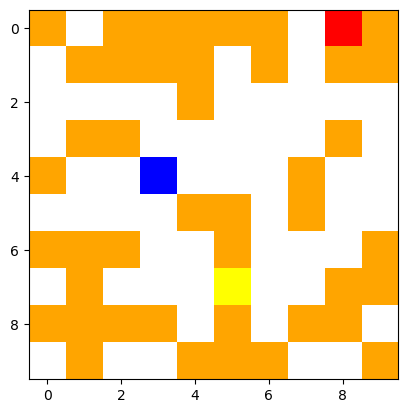

[10.84983653 10.88158381 10.84983653 10.84983653]
1
-0.005
Step 6


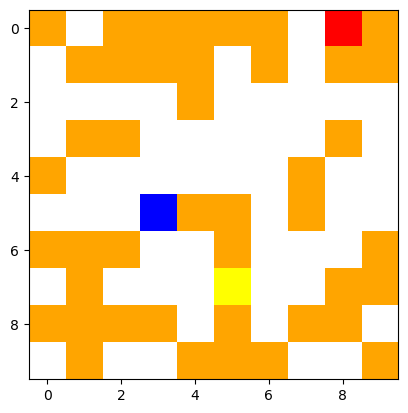

[10.86570223 10.89748129 10.86570223  9.88658381]
1
-0.005
Step 7


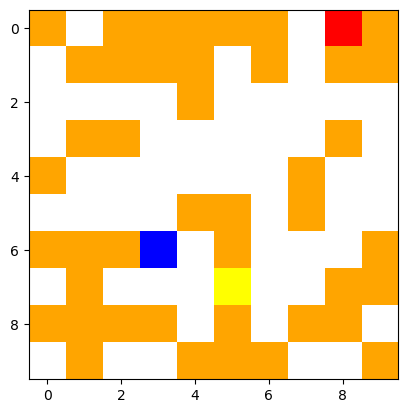

[10.88158381 10.91339469  9.90248129 10.91339469]
1
-0.005
Step 8


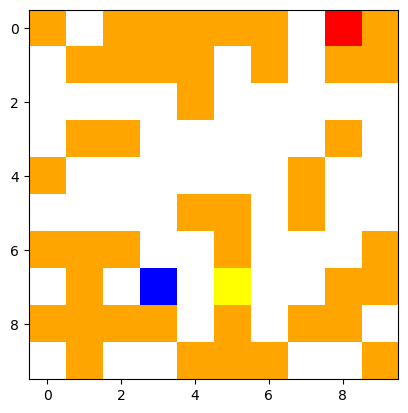

[10.89748129  9.91839469 10.89748129 10.92932401]
3
-0.005
Step 9


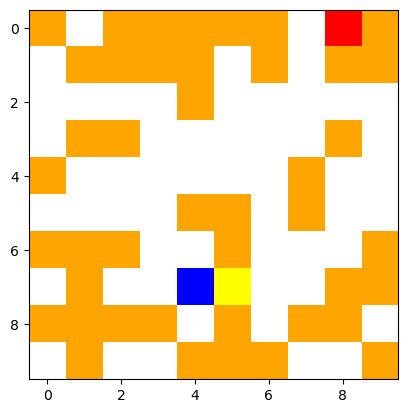

[10.91339469 10.91339469 10.91339469 10.94526928]
3
DING DING DOOOOOOOOOOONG
10
Step 10


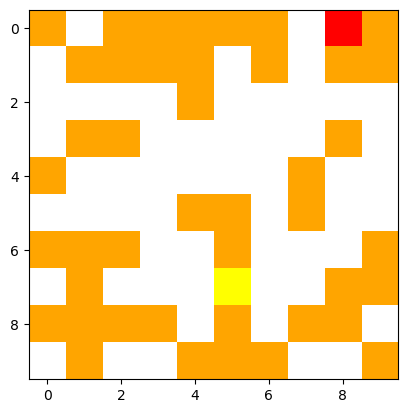

[-0.05473072 -0.05473072  0.93432901  0.9462155 ]
3
-0.005
Step 11


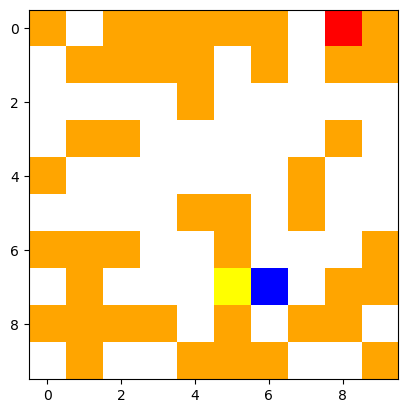

[0.95216766 0.94026928 0.94026928 0.94026928]
0
-0.005
Step 12


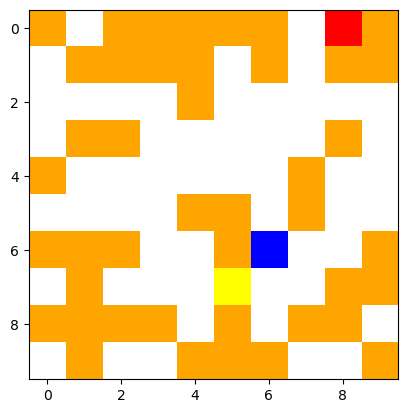

[ 0.95812579  0.9462155  -0.04283234  0.9462155 ]
0
-0.005
Step 13


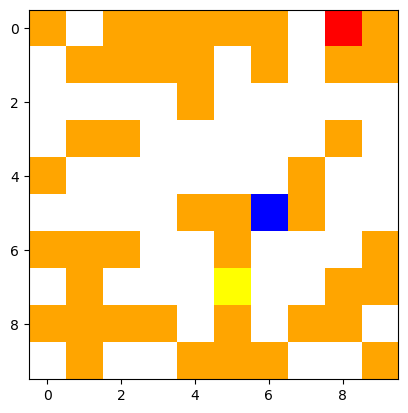

[ 0.96408988  0.95216766 -0.03687421 -0.03687421]
0
-0.005
Step 14


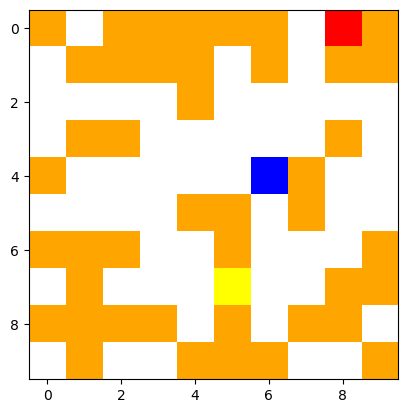

[ 0.97005994  0.95812579  0.95812579 -0.03091012]
0
-0.005
Step 15


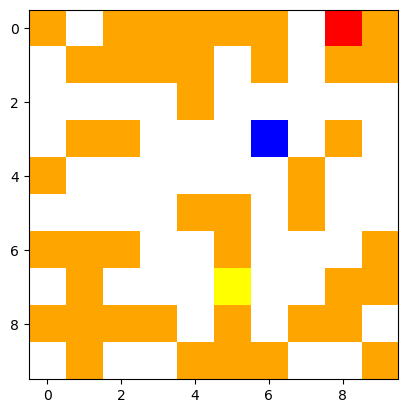

[0.97603598 0.96408988 0.96408988 0.97603598]
0
-0.005
Step 16


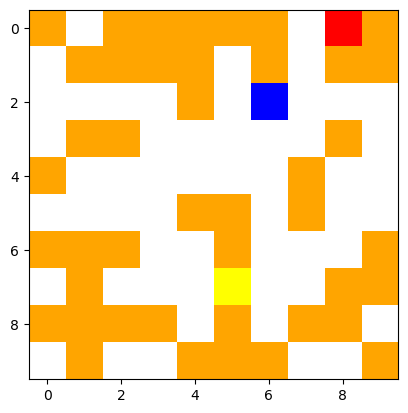

[-0.01896402  0.97005994  0.97005994  0.98201799]
3
-0.005
Step 17


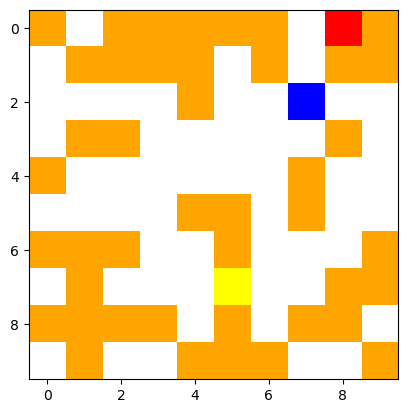

[0.988006   0.97603598 0.97603598 0.97603598]
0
-0.005
Step 18


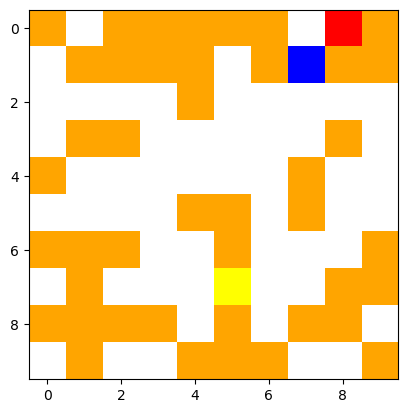

[ 0.994       0.98201799 -0.006994   -0.006994  ]
0
-0.005
Step 19


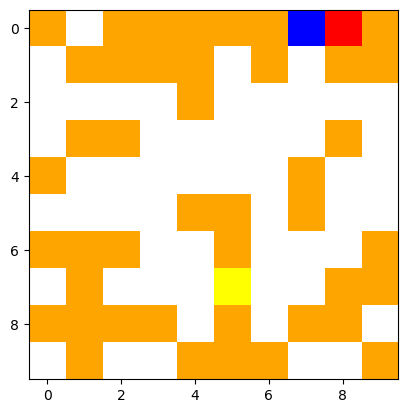

[-0.001     0.988006 -0.001     1.      ]
3
TRALALAAAAAAAAAAAAAAAAAAAAAA!
(0, 8)
1


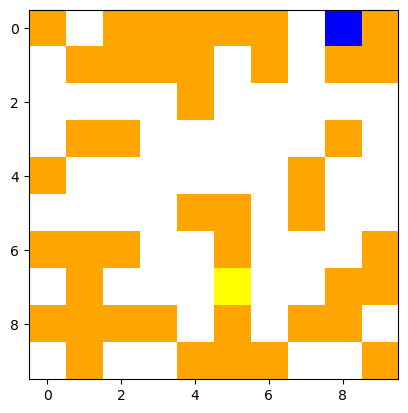

Episode Reward 10.909999999999993.Q matrix values:
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [-1.   0.  -1.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 9.8 10.8  9.8  9.8]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 9.8 10.8  9.8  9.8]
 [ 0.   0.   0.   0. ]
 [-0.  10.8  8.8 -1. ]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [10.8 10.8  9.8 10.8]
 [ 9.8  9.8 10.8 10.8]
 [ 9.8  9.8 10.8 10.8]
 [ 9.8 10.8 10.8  9.8]
 [ 0.   0.   0.   0. ]
 [10.8 10.8  9.8 10.8]
 [ 9.8 10.8 10.8 10.8]
 [ 9.8 10.8 10.8 10.8]
 [-1.  -1.  10.8 -0. ]
 [-1.  -0.   0.  -1. ]
 [10.8  9.8  9.8  9.8]
 [ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [10.8 10.9  9.9 10.8]
 [ 9.8 10.8 10.8 10.8]
 [10.8 10.8 10.8 10.8]
 [10.8 10.8 10.8 10.8]
 [10.8  9.8 10.8  9.8]
 [ 0.   0.   0.   0. ]
 [ 0.  -0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 9.8

In [29]:
q_learning.test(50)

In [30]:
q_learning.show_Q_spec((7,5))

[0. 0. 0. 0.]


In [ ]:
7
